### Prevendo preços das ações com yfinance

In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import os 
os.environ["KERAS_BACKEND"] = "tensorflow" 

from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None

2024-04-08 22:33:46.495639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 22:33:46.496206: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 22:33:46.499631: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 22:33:46.559927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 22:33:47.604602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Dados das ações

acao = "^BVSP" # Ibovespa

inicio = "2014-12-31"
final = "2024-04-08"

dados_acao = yf.download(acao, inicio, final)

dados_acao

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900
...,...,...,...,...,...,...
2024-04-01,128106.0,128659.0,126772.0,126990.0,126990.0,9372600
2024-04-02,126990.0,127654.0,126669.0,127549.0,127549.0,9073600
2024-04-03,127546.0,127694.0,126181.0,127318.0,127318.0,11032700


In [3]:
# Pegar as cotações de fechamento (preço real da ação)

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[ 48512.],
       [ 47517.],
       [ 48001.],
       ...,
       [127318.],
       [127428.],
       [126795.]])

In [4]:
# Treinar 80% e testar 20% dos dados

tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1835

In [5]:
# Escalar os dados entre 0 e 1, para deixar mais fácil o processamento

escalador = MinMaxScaler(feature_range=(0, 1))

dados_de_escala_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_de_escala_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_de_escala = list(dados_de_escala_treinamento.reshape(len(dados_de_escala_treinamento))) + list(dados_de_escala_teste.reshape(len(dados_de_escala_teste)))

dados_de_escala = np.array(dados_de_escala).reshape(len(dados_de_escala), 1)

dados_de_escala

array([[0.1180866 ],
       [0.10741968],
       [0.11260841],
       ...,
       [0.96292842],
       [0.96410768],
       [0.95732158]])

In [6]:
# Treinamento (Vamos prever os próximos dois meses(60 dias))

dados_para_treinamento = dados_de_escala[0: tamanho_dados_treinamento, :]

# Dados que serão usados para gerar o resultado
treinamento_x = []
# Cotação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):
    # Ultimos 60 dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    # Cotaçao
    treinamento_y.append(dados_para_treinamento[i, 0])
    
    if i <= 61:
        print(treinamento_x)
        print(treinamento_y)


[array([0.1180866 , 0.10741968, 0.11260841, 0.12828182, 0.13342767,
       0.12160293, 0.11409856, 0.11304795, 0.10880262, 0.11287642,
       0.12350047, 0.11000332, 0.11127907, 0.12571962, 0.12806741,
       0.1209061 , 0.11878343, 0.11893352, 0.10932793, 0.11004621,
       0.10089088, 0.10885623, 0.12293228, 0.1265451 , 0.12582682,
       0.12108835, 0.12742418, 0.11806516, 0.11517062, 0.12903226,
       0.140857  , 0.14776102, 0.14791111, 0.14731076, 0.14777174,
       0.15412901, 0.15345362, 0.15291759, 0.15100934, 0.1449844 ,
       0.14801831, 0.13905595, 0.13795174, 0.13383505, 0.12525863,
       0.11573881, 0.12231049, 0.12203175, 0.11898712, 0.1216887 ,
       0.13709409, 0.15039827, 0.14426613, 0.15512602, 0.15449351,
       0.15018386, 0.15395748, 0.14025665, 0.13505719, 0.14736436])]
[0.14636734956421066]
[array([0.1180866 , 0.10741968, 0.11260841, 0.12828182, 0.13342767,
       0.12160293, 0.11409856, 0.11304795, 0.10880262, 0.11287642,
       0.12350047, 0.11000332, 0.111

In [7]:
# Transformando as listas em arrays e dando reshape 3d

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)
treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

Criar um modelo com 50 neurônios

In [8]:
# Criando o Modelo
# return sequences-> True pois será utlizado outro modelo de LSTM
# Adicionando neurônios com o dense, 25 e 1
# Essa é uma das arquiteturas de deep learning (Bem que o Sergio podia pular logo para esse conteúdo)

modelo = Sequential()

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

/home/leandro/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

Copilando o modelo

A função de loss é a forma de medir o erro do modelo, que nesse caso é o classico erro médio quadrático que é usado em regressão linear

In [9]:
modelo.compile(optimizer="adam", loss="mean_squared_error") # least squares

In [10]:
# Treinamento
# Batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros
# Epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1775/1775 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0057


In [11]:
# Criar dados de teste
dados_teste = dados_de_escala[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [12]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [13]:
# Pegando predições do modelo
predicoes = modelo.predict(teste_x)

# Tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes # Reconvertando os dados originais

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


array([[110761.72 ],
       [110761.22 ],
       [110540.336],
       [110218.87 ],
       [109645.41 ],
       [108847.414],
       [107818.75 ],
       [106414.195],
       [104942.625],
       [103736.03 ],
       [102417.336],
       [101244.04 ],
       [100285.59 ],
       [ 99555.22 ],
       [ 98855.984],
       [ 98364.24 ],
       [ 98338.42 ],
       [ 98538.516],
       [ 98710.91 ],
       [ 98709.47 ],
       [ 98679.97 ],
       [ 98588.86 ],
       [ 98434.66 ],
       [ 98324.805],
       [ 98523.96 ],
       [ 98789.63 ],
       [ 98774.805],
       [ 98630.99 ],
       [ 98379.164],
       [ 97860.89 ],
       [ 97333.555],
       [ 96913.75 ],
       [ 96784.52 ],
       [ 96827.76 ],
       [ 97063.164],
       [ 97355.21 ],
       [ 97827.266],
       [ 98259.87 ],
       [ 98847.79 ],
       [ 99591.28 ],
       [100392.13 ],
       [100984.59 ],
       [101548.05 ],
       [102066.96 ],
       [102780.13 ],
       [103566.11 ],
       [104549.67 ],
       [10552

In [14]:
# Pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse # A resposta é o erro na moeda real

1258.8248570261437

In [15]:
# Criando o gráfico do modelo

treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:], "predicoes": predicoes.reshape(len(predicoes))})

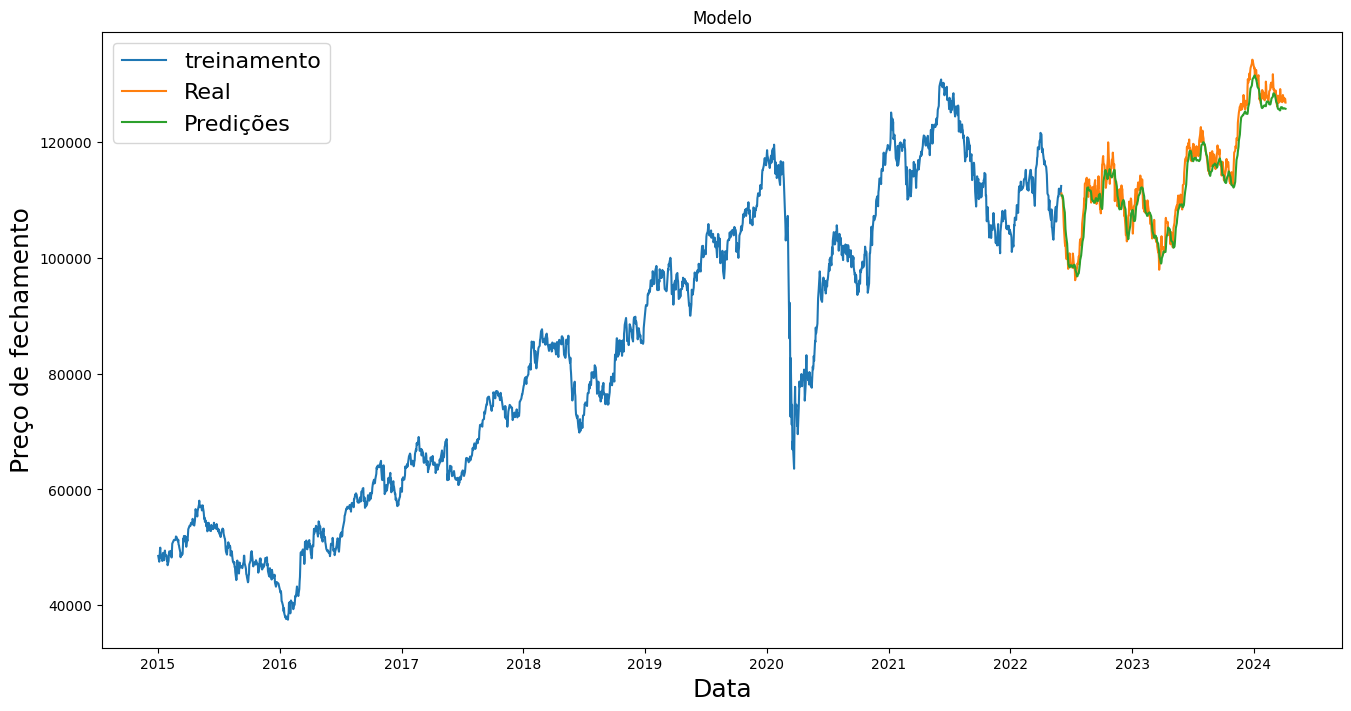

In [16]:
plt.figure(figsize=(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [17]:
df_teste.sort_index()
df_teste

,Close,predicoes
Date,,
2022-06-03,111102.0,110761.718750
2022-06-06,110186.0,110761.218750
2022-06-07,110070.0,110540.335938
2022-06-08,108368.0,110218.867188
2022-06-09,107094.0,109645.406250
...,...,...
2024-04-01,126990.0,125814.718750
2024-04-02,127549.0,125771.921875
2024-04-03,127318.0,125766.093750


https://www.youtube.com/watch?v=QSR0RCC3Mes&ab_channel=BrennoSullivan-VAROSQuant

https://medium.com/turing-talks/turing-talks-27-modelos-de-predi%C3%A7%C3%A3o-lstm-df85d87ad210